<a href="https://colab.research.google.com/github/kerryqliu/stats170/blob/kerry/doc2vec_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Pull info from database

In [ ]:
from sqlalchemy import create_engine

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
testQuery = "SELECT d.docid, f.fulltext, d.label from fullDocuments f join documentLabels d on f.docid = d.docid;"
docs = pd.read_sql_query(testQuery, con=engine)
docs

,docid,fulltext,label
0,1,Document Text: Example 1\nReferring Doctor: Un...,1.0
1,2,Document Text: Example 2\nProgress Notes\nDate...,1.0
2,3,Document Text: Example 3\nChief Complaint:\n1....,4.0
3,4,Document Text: 14\nse\nLAIDA\n*\nPatient Infor...,1.0
4,5,Document Text: The first set of documents behi...,1.0
...,...,...,...
110,111,Document Text: 9:10\nFAX\n2002/041\n'\nPatient...,1.0
111,112,Document Text: # 23/24\nfined VI\nvyy\nScan on...,1.0
112,113,Document Text: 15:03 From\nPage: 1/24\nNUFACTO...,1.0
113,114,Document Text: 03:58:42 p.m.\n1/2\nNU FACTOR\n...,2.0


In [ ]:
testD = docs[docs['docid'] == 66].reset_index()
testD[testD['label'] != 0]

,index,docid,sentencenum,sentence,label
0,4561,66.0,1.0,Document Text: 14:08\nPAGE\n04/11\nPatient Nam...,1.0
1,4562,66.0,2.0,He did have profound evidence of neuropathy on...,1.0
8,4569,66.0,9.0,Localized Osteoarthritis Of The Knee 715.36\n4.,1.0
9,4570,66.0,10.0,Muscle Weakness 728.87\n5.,1.0
10,4571,66.0,11.0,Numbness (Hypesthesia) 782.0\n6.,1.0
16,4577,66.0,17.0,Muscle Weakness 728.87\n2.,1.0
17,4578,66.0,18.0,Numbness (Hypesthesia) 782.0\n3.,1.0
18,4579,66.0,19.0,Chronic Inflammatory Demyelinating Polyneuropa...,1.0
22,4583,66.0,23.0,He has noticed significant impairment in ambul...,1.0
25,4586,66.0,26.0,He states that he has significant difficulty g...,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


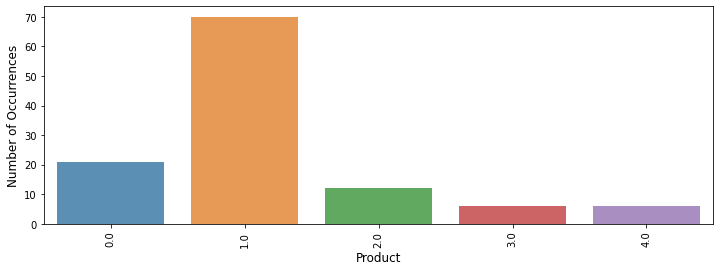

In [ ]:
cnt_pro = docs['label'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
cnt_pro

1.0    70
0.0    21
2.0    12
3.0     6
4.0     6
Name: label, dtype: int64

# Text Pre-Processing

In [ ]:
import nltk
from gensim.models.phrases import Phrases
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = text.lower()
    text = re.sub(r'[.,!?]', ' ', text)
    text = re.sub(r'\n', ' ', text)
    return text

Train bigram thing

In [ ]:
query = "SELECT * from docSentences"
sentences = pd.read_sql_query(query, con=engine)
sentences

,docid,sentencenum,sentence
0,1.0,1.0,Document Text: Example 1\nReferring Doctor: Un...
1,1.0,2.0,He noted trouble Dorsey and plantar flexing th...
2,1.0,3.0,This presented without pain numbness or parest...
3,1.0,4.0,He also noted some\nweakness of his left hip a...
4,1.0,5.0,In he states mentions someone spike does drink...
...,...,...,...
7803,115.0,78.0,Comments\nThe MP Evaluation analyzes an indivi...
7804,115.0,79.0,This analysis did not detect any abnormallyele...
7805,115.0,80.0,"Therefore, it is unlikelythat this individual'..."
7806,115.0,81.0,No.


In [ ]:
fullSentences = []
for i, row in sentences.iterrows():
  fullSentences.append(nltk.word_tokenize(cleanText(row['sentence'])))
fullSentences[30]

NameError: ignored

In [ ]:
len(fullSentences)

7808

In [ ]:
bigram = Phrases(fullSentences, min_count=10, threshold=10) #will have to tweak these thresholds

# Now back to the test/train split

In [ ]:
train, test = train_test_split(docs, test_size=0.3, random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        sent = cleanText(sent)
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens #trying this with the bigrams

In [ ]:
train_tagged.values[30]

TaggedDocument(words=['document', 'text', '03/08', 'page', 'mal', 'legakuna', 'wath', 'order', 'for', 'the', 'brand', 'name', 'wwnte', 'dedicafli', '19there', 'mriots', '12:31', '09/25/2013', '12:31', 'page', '04/08', 'soap', 'note', 'for', 'age', 'on', 'dos', '60', 'yrs', 'dob', 'seen', 'by', 'seen', 'on', 'friday', 'bmi', 'vs', 'height', '70', 'in', 'weight', '312', '06', '44', 'las', 'www', 'www', 'wwwwww', 'cc', 'neurological', 'consult', 'ref', 'dr', 'appt', 'time', '9:15', 'am', 'arrival', 'time', '1:29', 'pm', 'in', 'history', 'of', 'present', 'illness', 'the', 'patient', 'is', '60-year-old', 'gentleman', 'accompanied', 'with', 'the', 'wife', 'for', 'neurological', 'evaluations', 'he', 'is', 'right-handed', 'he', 'is', 'being', 'seeing', 'neurologist', 'who', 'initially', 'diagnosed', 'cidp', 'that', 'is', 'chronic', 'inflammatory', 'demyelinating', 'polyneuropathy', 'records', 'reviewed', 'and', 'the', 'patient', 'had', 'been', 'on', 'iv', 'solu-medrol', 'for', 'the', 'last', '

# Start Training

In [ ]:
import multiprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectPercentile, f_classif
cores = multiprocessing.cpu_count()

In [ ]:
# consider scaling the vectors?
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=100)) for doc in sents])
    return targets, regressors

This code block below runs the train

In [ ]:
accuracy = []
f1 = []
mean_acc = []
mean_f1 = []
train_dict = dict()
test_dict = dict()
kfold = StratifiedKFold(n_splits=6, shuffle=True)
C = [10000, 1000, 100, 10, 1, .1,.01,.001]
for term in C:
  test_acc = []
  train_acc = []
  for i in range(5):
    for train, test in kfold.split(docs['fulltext'], docs['label']):
      # set up the model below
      train, test = docs.iloc[train], docs.iloc[test]
      
      y_train, X_train = vec_from_model(model, train)
      y_test, X_test = vec_from_model(model, test)

      logreg = LogisticRegression(penalty = 'l1', n_jobs=1, C=1e5, max_iter = 600, solver='saga')
      logreg.fit(X_train, y_train)
      y_pred = logreg.predict(X_test)
      y_train_pred = logreg.predict(X_train)
      from sklearn.metrics import accuracy_score, f1_score
      # print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
      # print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
      test_acc.append(accuracy_score(y_test, y_pred))
      train_acc.append(accuracy_score(y_train, y_train_pred))
      f1.append(f1_score(y_test, y_pred, average='weighted'))
      y_preds.append(y_pred)
      y_tests.append(y_test)
    train_dict[term] = train_acc
    test_dict[term] = test_acc

print("Mean accuracy: ", np.mean(accuracy))
print("Mean F1: ", np.mean(f1))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Testing accuracy 0.55
Testing F1 score: 0.5752525252525252


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Testing accuracy 0.42105263157894735
Testing F1 score: 0.40421052631578946


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Testing accuracy 0.3684210526315789
Testing F1 score: 0.3839712918660287


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Testing accuracy 0.47368421052631576
Testing F1 score: 0.4661654135338346


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Testing accuracy 0.42105263157894735
Testing F1 score: 0.3859649122807018
Testing accuracy 0.5263157894736842
Testing F1 score: 0.5263157894736842
Mean accuracy:  0.46008771929824555
Mean F1:  0.45698007645376065


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
total = 0
wrong = 0
wrong_label = []
for i in range(len(y_test)):
  if y_test[i] != y_pred[i]:
    wrong_label.append((y_test[i], y_pred[i]))
    wrong += 1
  total += 1
print(wrong / total)

0.42105263157894735


In [ ]:
equal_0 = 0
not_0 = 0
for i in y_test:
  if i == 0:
    equal_0 += 1
  else:
    not_0 += 1
print(not_0 / equal_0)

3.75


In [ ]:
for i in wrong_label:
  print("Right label: ", i[0], " Predicted label: ", i[1])


Right label:  2.0  Predicted label:  1.0
Right label:  0.0  Predicted label:  1.0
Right label:  4.0  Predicted label:  1.0
Right label:  0.0  Predicted label:  1.0
Right label:  3.0  Predicted label:  1.0
Right label:  0.0  Predicted label:  1.0
Right label:  0.0  Predicted label:  1.0
Right label:  2.0  Predicted label:  1.0


In [ ]:
y_preds

[array([1., 4., 1., 1., 2., 1., 1., 1., 0., 3., 0., 2., 1., 0., 1., 1., 0.,
        1., 0., 4.]),
 array([1., 1., 4., 1., 1., 2., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
        1., 1.]),
 array([1., 1., 4., 1., 1., 2., 1., 1., 0., 3., 0., 2., 1., 0., 0., 1., 1.,
        0., 1.]),
 array([1., 1., 4., 1., 1., 1., 1., 1., 0., 3., 0., 2., 1., 1., 0., 1., 1.,
        0., 1.]),
 array([1., 2., 1., 1., 1., 3., 2., 1., 1., 0., 1., 1., 1., 1., 4., 1., 1.,
        1., 0.]),
 array([1., 1., 4., 1., 1., 2., 1., 0., 3., 0., 2., 1., 1., 1., 1., 0., 1.,
        1., 0.])]

# Try naive bayes


In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
accuracy = []
f1 = []
kfold = StratifiedKFold(n_splits=6, shuffle=True)
for train, test in kfold.split(docs['fulltext'], docs['label']):
  train, test = docs.iloc[train], docs.iloc[test]
  train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['fulltext']), tags=[r.label]), axis=1)
  test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['fulltext']), tags=[r.label]), axis=1)
  model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores) #change doc2vec params here
  model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
  for epoch in range(60): # modify epochs on this line
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha
  y_train, X_train = vec_for_learning(model_dbow, train_tagged)
  y_test, X_test = vec_for_learning(model_dbow, test_tagged)


  model = GaussianNB()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  from sklearn.metrics import accuracy_score, f1_score
  print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
  print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
  accuracy.append(accuracy_score(y_test, y_pred))
  f1.append(f1_score(y_test, y_pred, average='weighted'))

print("Mean accuracy: ", np.mean(accuracy))
print("Mean F1: ", np.mean(f1))

100%|██████████| 95/95 [00:00<00:00, 346787.54it/s]


NameError: ignored

# Testing cross-val

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
print(metrics.SCORERS.keys())

NameError: ignored

In [ ]:
C = [10, 1, .1, 0.05,.01,.001] # As C decreases, more coefficients go to zero
tagged = docs.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['fulltext']), tags=[r.label]), axis=1)
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores) #change doc2vec params here
model_dbow.build_vocab([x for x in tqdm(tagged.values)])
for epoch in range(60): # modify epochs on this line
    model_dbow.train(utils.shuffle([x for x in tqdm(tagged.values)]), total_examples=len(tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

y, X = vec_for_learning(model_dbow, tagged)
logreg = LogisticRegression(penalty = 'l1', n_jobs=1, C=0.001, max_iter = 600, solver='saga')
scores = cross_val_score(logreg, X, y, cv=6, scoring="f1_micro")  #<-- add this
print(scores)

100%|██████████| 115/115 [00:00<00:00, 67659.55it/s]


[0.6        0.63157895 0.63157895 0.63157895 0.57894737 0.57894737]


# BioSentVec

In [ ]:
!git clone https://github.com/epfml/sent2vec.git

Cloning into 'sent2vec'...
remote: Enumerating objects: 396, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 396 (delta 0), reused 1 (delta 0), pack-reused 393
Receiving objects: 100% (396/396), 439.62 KiB | 3.63 MiB/s, done.
Resolving deltas: 100% (247/247), done.


In [ ]:
%cd sent2vec

/content/sent2vec


In [ ]:
!python setup.py build_ext
!pip install .

Compiling src/sent2vec.pyx because it changed.
[1/1] Cythonizing src/sent2vec.pyx
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/sent2vec/src/sent2vec.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'sent2vec' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/src
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -Isrc -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I/usr/include/python3.7m -c src/sent2vec.cpp -o build

In [ ]:
import sent2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from scipy.spatial import distance

In [ ]:
model_path = '/content/drive/Shareddrives/CAPSTONE/Resources/BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
model = sent2vec.Sent2vecModel()
try:
    model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

    return ' '.join(tokens)

In [ ]:

sentence = preprocess_sentence('Breast cancers with HER2 amplification have a higher risk of CNS metastasis and poorer prognosis.')
print(sentence)

breast cancers her2 amplification higher risk cns metastasis poorer prognosis


In [ ]:
sentence_vector = model.embed_sentence(cleanText(docs.iloc[0].fulltext))
print(sentence_vector)

[[ 8.45276043e-02 -6.87525123e-02 -1.06800728e-01  1.02193626e-02
   9.78189334e-02  3.15079391e-02 -1.59355462e-01 -1.11872004e-02
  -2.25515272e-02  1.31053194e-01 -3.38694528e-02  9.62441042e-02
  -6.52141720e-02  1.03560194e-01 -2.28478715e-01  1.16908528e-01
   1.34467185e-01  5.45061739e-05  1.06577247e-01 -5.38287275e-02
   2.56129857e-02 -1.08107403e-01  1.73410311e-01 -9.63028744e-02
   4.81515341e-02 -8.13638791e-02 -3.32979001e-02 -9.13036019e-02
  -3.06553133e-02  9.41503048e-02  3.22709382e-02  1.03148110e-01
  -3.46005745e-02  3.56390998e-02  2.55638584e-02 -1.19112611e-01
   2.11183980e-01  8.58275127e-03 -1.87927917e-01 -2.09158659e-01
  -6.89666569e-02  6.03563823e-02 -1.16714150e-01 -2.67234109e-02
   7.03885183e-02 -4.17933278e-02  8.71311203e-02  4.21305001e-02
   3.39420587e-02  5.39152212e-02 -8.23790282e-02  8.41117799e-02
   1.80534851e-02  4.68766689e-02 -2.03267083e-01 -8.17626417e-02
  -1.16171055e-01 -9.79005322e-02  6.47702664e-02  1.26641124e-01
  -1.14824

In [ ]:
# Function for pubmeb vectors
# consider scaling the vectors?
def vec_from_model(model, df):
    labels = []
    vectors = []
    for i in range(len(df)):
      labels.append(df.iloc[i].label)
      vectors.append(model.embed_sentence(cleanText(docs.iloc[i].fulltext))[0])
    return labels, vectors

Repeated k-fold cross validation

In [ ]:
accuracy = []
f1 = []
mean_acc = []
mean_f1 = []
train_dict = dict()
test_dict = dict()
train_f1_dict = dict()
test_f1_dict = dict()
kfold = StratifiedKFold(n_splits=6, shuffle=True)
C = [10000, 1000, 100, 10, 1, .1,.01,.001]
for term in C:
  train_dict[term] = []
  test_dict[term] = []
  train_f1_dict[term] = []
  test_f1_dict[term] = []
  for i in range(5):
    test_acc = []
    train_acc = []
    train_f1 = []
    test_f1 = []
    for train, test in kfold.split(docs['fulltext'], docs['label']):
      # set up the model below
      train, test = docs.iloc[train], docs.iloc[test]
      
      y_train, X_train = vec_from_model(model, train)
      y_test, X_test = vec_from_model(model, test)

      logreg = LogisticRegression(penalty = 'l1', n_jobs=1, C=term, max_iter = 600, solver='saga')
      logreg.fit(X_train, y_train)
      y_pred = logreg.predict(X_test)
      y_train_pred = logreg.predict(X_train)
      from sklearn.metrics import accuracy_score, f1_score
      # print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
      # print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
      test_acc.append(accuracy_score(y_test, y_pred))
      train_acc.append(accuracy_score(y_train, y_train_pred))
      test_f1.append(f1_score(y_test, y_pred, average='weighted'))
      train_f1.append(f1_score(y_train, y_train_pred, average='weighted'))
      # y_preds.append(y_pred)
      # y_tests.append(y_test)
    train_dict[term].append(train_acc)
    test_dict[term].append(test_acc)
    train_f1_dict[term].append(train_f1)
    test_f1_dict[term].append(test_f1)

print("Mean accuracy: ", np.mean(accuracy))
print("Mean F1: ", np.mean(f1))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Mean accuracy:  nan
Mean F1:  nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
for key in test_dict:
  print("Key: ", key, " Values: ", str(test_f1_dict[key]))

Key:  10000  Values:  [[0.3652173913043478, 0.38215102974828374, 0.45414673046251997, 0.3684210526315789, 0.35240274599542337, 0.4651847008826414], [0.4444444444444445, 0.4295521412226218, 0.2296650717703349, 0.42162471395881, 0.3508771929824562, 0.3859649122807018], [0.4, 0.40421052631578946, 0.48086124401913877, 0.518796992481203, 0.5982456140350877, 0.5146198830409358], [0.3, 0.4821837201699902, 0.3684210526315789, 0.3684210526315789, 0.47368421052631576, 0.41901856089499107], [0.35, 0.3295194508009153, 0.43935926773455375, 0.3844393592677346, 0.5087719298245613, 0.38596491228070173]]
Key:  1000  Values:  [[0.4153846153846154, 0.6483253588516746, 0.4295521412226218, 0.42105263157894735, 0.3546910755148741, 0.3684210526315789], [0.35, 0.4788329519450801, 0.3684210526315789, 0.3031578947368421, 0.402745995423341, 0.2673350041771095], [0.49444444444444446, 0.5295848316443281, 0.42105263157894735, 0.3844393592677346, 0.3684210526315789, 0.6716791979949874], [0.3730769230769231, 0.474664

In [ ]:
train_dict[0.001]

[[0.6105263157894737,
  0.6041666666666666,
  0.6041666666666666,
  0.6041666666666666,
  0.6145833333333334,
  0.6145833333333334],
 [0.6105263157894737,
  0.6041666666666666,
  0.6041666666666666,
  0.6041666666666666,
  0.6145833333333334,
  0.6145833333333334],
 [0.6105263157894737,
  0.6041666666666666,
  0.6041666666666666,
  0.6041666666666666,
  0.6145833333333334,
  0.6145833333333334],
 [0.6105263157894737,
  0.6041666666666666,
  0.6041666666666666,
  0.6041666666666666,
  0.6145833333333334,
  0.6145833333333334],
 [0.6105263157894737,
  0.6041666666666666,
  0.6041666666666666,
  0.6041666666666666,
  0.6145833333333334,
  0.6145833333333334]]

In [ ]:
mean_test_acc = []
mean_train_acc = []
mean_test_f1 = []
mean_train_f1 = []
for key in train_dict:
  mean_test_acc.append(np.mean([np.mean(i) for i in test_dict[key]]))
  mean_train_acc.append(np.mean([np.mean(i) for i in train_dict[key]]))
  mean_test_f1.append(np.mean([np.mean(i) for i in test_f1_dict[key]]))
  mean_train_f1.append(np.mean([np.mean(i) for i in train_f1_dict[key]]))

In [ ]:
mean_test_acc

[0.41078947368421054,
 0.41912280701754384,
 0.42622807017543857,
 0.5583333333333333,
 0.6087719298245614,
 0.6087719298245614,
 0.6087719298245614,
 0.6087719298245614]

In [ ]:
mean_test_f1

[0.41253899681130807,
 0.4181099620779255,
 0.42561190635790175,
 0.45316291285178745,
 0.4610026410111299,
 0.4610026410111299,
 0.4610026410111299,
 0.4610026410111299]

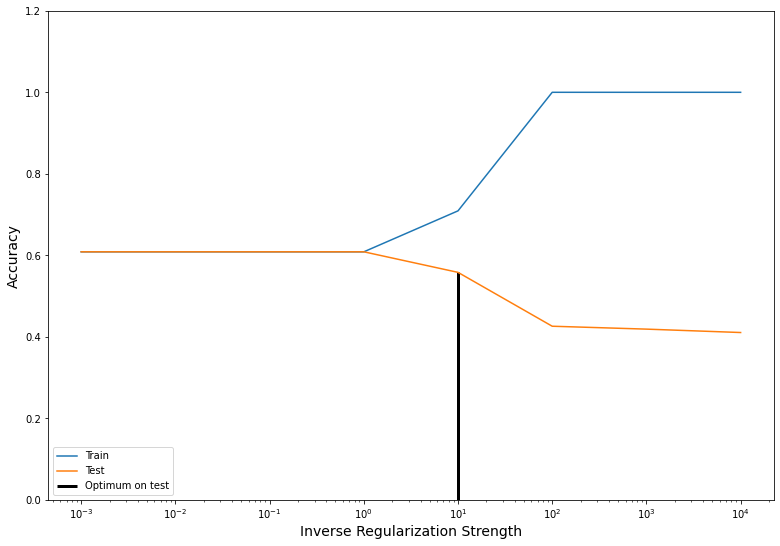

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,9))
plt.semilogx(C, mean_train_acc, label='Train')
plt.semilogx(C, mean_test_acc, label='Test')
plt.ylim([0, 1.2])
plt.vlines(10, plt.ylim()[0], 0.5583333333333333, color='k',
           linewidth=3, label='Optimum on test')
plt.xlabel('Inverse Regularization Strength', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower left')
plt.show()

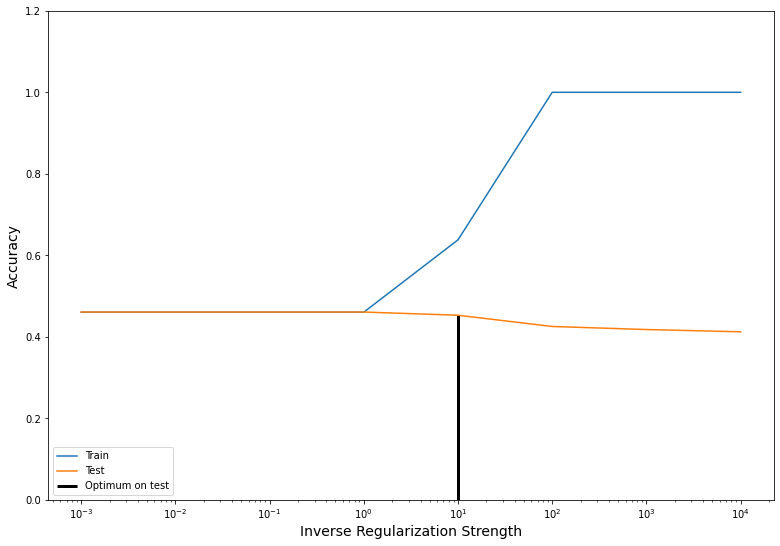

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,9))
plt.semilogx(C, mean_train_f1, label='Train')
plt.semilogx(C, mean_test_f1, label='Test')
plt.ylim([0, 1.2])
plt.vlines(10, plt.ylim()[0], 0.45316291285178745, color='k',
           linewidth=3, label='Optimum on test')
plt.xlabel('Inverse Regularization Strength', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower left')
plt.show()